### Algorithm:

1. Create a Map with Minkowsky consideration
2. Convert Image into Grid
3. Apply Dijkstra's Algorithm
4. Run Dijkstra's and store video
5. Apply A* algorithm
6. Run A* and store video

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Step1: Create a Map for:
    a. Point Robot
    b. Rigid Robot

In [43]:
class CreateMap:
    
    def __init__(self, minkowski_required=False, robot_radius=0, clearance=0):
        self.minkowski_req = minkowski_required
        self.minkowski_dis = robot_radius + clearance
    
    # Creating the Circular Obstacle.
    def inside_a_circle(self, point):
        # @ point be in format: [x, y]
        x, y = point[0], point[1]
        if self.minkowski_req == True:
            radius = 15 + self.minkowski_dis
        else:
            radius = 15

        if ((x-20)**2 + (y-190)**2) <= (radius**2):
            return True
        else:
            return False
    
    # Creating the ellipse obstacle
    def inside_an_ellipse(self, point):

        x, y = point[0], point[1]

        if self.minkowski_req == True:
            min_axis = 12 + self.minkowski_dis
            maj_axis = 30 + self.minkowski_dis
        else:
            min_axis = 12
            maj_axis = 30

        if (((x-30)**2)/min_axis**2 + ((y-140)**2)/maj_axis**2) <= 1:
            return True
        else:
            return False
        
    # Creating Rectangle Equations; Half Planes.
    def inside_a_rectangle(self, point):
        x, y = point[0], point[1]

        if self.minkowski_req == True:
            offset = self.minkowski_dis
        else:
            offset = 0

        if (x<=83.5+offset) and (y<=100+offset) and (x>=33.5-offset) and (y>=50-offset):
            return True
        else:
            return False

    # Writing Polygon Equations; Half Planes.
    def inside_a_polygon(self, point):
        x, y = point[0], point[1]

        if self.minkowski_req == True:
            offset = self.minkowski_dis
        else:
            offset = 0

        h1 = (x<=135+offset)
        h2 = (y<=-0.5405*x+245.97+offset)

        h3 = (x>=98)
        h9 = (x<=98)

        h4 = (y>=-0.35135*x+197.4324)
        h10 =(y<=-0.35135*x+197.4324)

        h5 = (y<=0.60526*x+133.684+offset)
        h6 = (y>=-0.1842*x+181.0526-offset)
        h7 = (y<=9.5*x-768+offset)
        h8 = (y>=0.609756*x+67.6829-offset)


        # Convex Sets
        convex_set_1 = h1 and h2 and h3 and h4
        convex_set_2 = h5 and h6 and h9
        convex_set_3 = h10 and h7 and h8
        if convex_set_1 or convex_set_2 or convex_set_3:
            return True
        else:
            return False
    
    def create_map(self):
        # Create a white background
        background = np.zeros((150,250,3), np.uint8)# Height, Width: Numpy nomenclature.
        background[:,:] = (255, 255, 255)# White Background
        
        # Returns a Obstacle Map without minkowsky distance.
        image_copy = background.copy()
        for x in range(150):
            for y in range(250):
                point = [x, y]
                if self.inside_a_circle(point) or self.inside_an_ellipse(point) or self.inside_a_rectangle(point) or self.inside_a_polygon(point):
                    image_copy[x,y] = (0,0,0)
                else:
                    continue
        return image_copy

    def create_map_minkowski_equations(self):
        self.minkowski_req = True
        # Create a white background
        background = np.zeros((150,250,3), np.uint8)# Height, Width: Numpy nomenclature.
        background[:,:] = (255, 255, 255)# White Background
        
        # Returns a Obstacle Map without minkowsky distance.
        map_image_copy = background.copy()
        for x in range(150):
            for y in range(250):
                point = [x, y]
                if self.inside_a_circle(point) or self.inside_an_ellipse(point) or self.inside_a_rectangle(point) or self.inside_a_polygon(point):
                    map_image_copy[x,y] = (0,0,0)
                else:
                    continue
        return map_image_copy

    def create_map_minkowski_contours(self, image):
        # @ input image of map without minkowski distance.
        # Returns a Obstacle Map without minkowski distance.
        map_image_copy = image.copy()
        edges = cv2.Canny(map_image_copy,100,200)
        contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(map_image_copy, contours, -1, (0,255,0), 1)
        contours = np.array(contours).squeeze()

        for shapes in contours:
            for contour_of_shape in shapes:
                [x,y] = contour_of_shape.squeeze()
                rad_circle = self.minkowski_dis
                cv2.circle(map_image_copy, (x,y), rad_circle, (0,0,0), -1)
        return map_image_copy

### Step 2: Convert Image into Grid

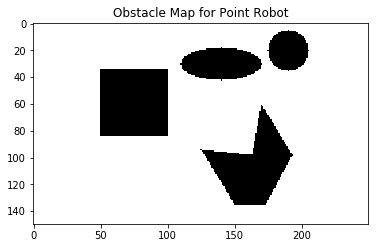

In [52]:
# Creating Map for Point Robot.
obj = CreateMap()
map_image = obj.create_map()
plt.title('Obstacle Map for Point Robot')
plt.imshow(map_image)
plt.show()

(150, 250, 3)


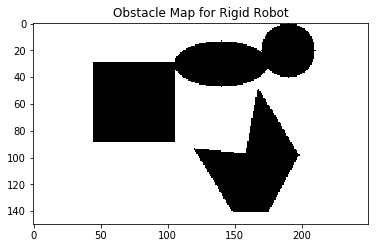

In [55]:
# Creating Map for Rigid Robot
obj = CreateMap(robot_radius=5, clearance =0)
minkowski_map = obj.create_map_minkowski_equations()# For using equations to create minkowski map
print(minkowski_map.shape)
# map_image = obj.create_map()# For using contours to create minkowski map
# minkowski_map = obj.create_map_minkowski_contours(map_image)# For using contours to create minkowski map
plt.imshow(minkowski_map)
plt.title('Obstacle Map for Rigid Robot')
plt.show()

In [109]:
def convert_to_grid(image, resolution=1):
    grid = np.zeros((image.shape[0], image.shape[1]))
    # Discretizing the Image in grids
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if image[x][y][1] == 0:
                grid[x,y] = 1# grid contains 1 for obstacles.
    return grid

In [148]:
grid = convert_to_grid(minkowski_map)
obstacles = list(np.argwhere(grid == 1))# Storing the coordinates of positions where we have obstacles.
# Converting list into tuples for easy access.
obstacles_tuples = []
for obst in obstacles:
    obstacles_tuples.append((obst[0],obst[1]))

### Step 3: Dijkstra's Algorithm

In [149]:
from collections import namedtuple

In [156]:
Color = namedtuple('Cddlor', ['red','green','blue'])
color = Color(55,155,255)

print(color.blue)

255


In [5]:
class PathPlanning:
    
    # Step 1: Read Inputs
    def __init__(self, robot_radius, clearance, resolution, start, goal):
        self.radius = robot_radius
        self.clearance = clearance
        self.resolution = resolution
        self.start = start
        self.goal = goal
    
    def give_me_a_line(self, point1, point2):
        # @ returns line parameters m and c for two points; y = mx + c
        # points expected in format: [x1,y1] and [x2,y2]
        try:
            m = (point2[1]-point1[1])/(point2[0]-point1[0])
            c = (point1[1]*point2[0] - point1[0]*point2[1])/(point2[0]-point1[0])
        except:
            m = 'x = '
            c = point1[0]
        return m, c
    
    # Step 2: Create an image map with cobs as black
    def create_obstacles(self):
        
        # Placing obstacles on the map
        background = np.zeros((150,250,3), np.uint8)# 3 - Channels
        background[:,:] = (255, 255, 255)# White Background
        
        # Drawing a rectangle.
        cv2.rectangle(background, (50,37), (100,82), (0,0,0), -1)
        
        # Drawing an ellipse
        cv2.ellipse(background,(140, 30),(15,6),0,0,360,(0,0,0),-1)
        
        # Drawing a circle
        cv2.circle(background, (190, 20), 15, (0,0,0), -1)
        
        # Drawing a polygon
        points = np.array([[125,94],[163,98],[170,60],[193,98],[173,135],[150,135]], np.int32)
        points = points.reshape((-1,1,2))
        cv2.polylines(background,[points], True, (0,0,0))
        cv2.fillPoly(background, [points], (0,0,0))
        
        return background
    
    # Step 3: Add Minkwoski Distance
        

In [6]:
robot_radius = 10
clearance = 0
resolution = 10
start = 1
goal = 10

In [16]:
obj = PathPlanning(robot_radius, clearance, resolution, start, goal)
point1 = [135,150]
point2 = [135,173]
point3 = [98,193]
point4 = [60,170]
point5 = [98,163]
point6 = [94,125]

m,c = obj.give_me_a_line(point6,point1)
print(m, c)

# cv2.imshow('MAP',MAP)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

0.6097560975609756 67.6829268292683
